# Objective
This study is a comparative exploration of simple neural networks for digit classification, with a two-fold goal: develop a neural network model for highly-accurate (99 percent-range) digit classification and gain an in-depth understanding of how the neurons in the simple single-hidden layer network have learned to represent features within the input data.  A comparison and evaluation of simple single hidden-layer networks with varying architectures (with respect to width and dimensionality) helps determine their potential utility in multi-class classification problems on the MNIST dataset of hand-drawn digits and for future analogous Optical Character Recognition (OCR) efforts. 

In [1]:
# Import dependencies
import numpy as np
import pandas as pd
import os
import time

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import models
from tensorflow.keras import layers
from tensorflow.keras.wrappers.scikit_learn import KerasClassifier
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import KFold, GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.decomposition import PCA

%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
# Check versions
print(keras.__version__)
print(tf.__version__)

2.2.4-tf
2.0.0


In [3]:
tf.compat.v1.disable_eager_execution() 

In [4]:
# For consistent results
keras.backend.clear_session()
np.random.seed(42)
tf.random.set_seed(42)

# Data import and pre-processing

In [5]:
# Import data from Keras
from tensorflow.keras.datasets import mnist
(train_images, train_labels), (test_images, test_labels) = mnist.load_data()

In [6]:
# Check shapes
train_images.shape, test_images.shape, test_labels.shape, test_labels.shape

((60000, 28, 28), (10000, 28, 28), (10000,), (10000,))

Preprocess data by reshaping it into the shape that the network expects and scaling it so that all values are in the \[0, 1] interval.
- Training images are stored in an array of shape (60000, 28, 28) of type uint8 with values in the [0, 255] interval. 
- Transform images it into a float32 array of shape (60000, 28 * 28) with values between 0 and 1.

In [7]:
train_images = train_images.reshape((60000, 28 * 28))
train_images = train_images.astype('float32') / 255

test_images = test_images.reshape((10000, 28 * 28))
test_images = test_images.astype('float32') / 255

In [8]:
# Set apart 5,000 samples from training data for validation
val_images, train_images = train_images[:5000], train_images[5000:] 
val_labels, train_labels = train_labels[:5000], train_labels[5000:]

# EXPERIMENT  1:

This network will consist of 784 input nodes, a hidden layer with `1 node` and 10 output nodes (corresponding to the 10 digits). We use `mnist.load_data()` to get the 70,000 images divided into a set of 60,000 training images and 10,000 test images. 5,000 of the 60,000 training images are held back for validation. After training the model, we group the 60,000 `activation values` of the hidden node for the (original) set of training images by the 10 predicted classes and visualize these sets of values using a `boxplot`. The overlap between the range of values in the "boxes" is expected to be minimal.

## Build network

This network consists of a sequence of two `Dense` layers, which are densely-connected (also called "fully-connected") neural layers. 

* The first `Dense` layer, the hidden layer, consists of just `one node`.
* The second (and last) layer is a 10-way "softmax" layer, which means it will return an array of 10 probability scores (summing to 1). Each  score will be the probability that the current digit image belongs to one of our 10 digit classes.

In [9]:
# Define model using Sequential class
# reLu activation
model_1 = models.Sequential()
model_1.add(layers.Dense(1, activation='relu', input_shape=(28 * 28,)))
model_1.add(layers.Dense(10, activation='softmax')) 

Instructions for updating:
If using Keras pass *_constraint arguments to layers.


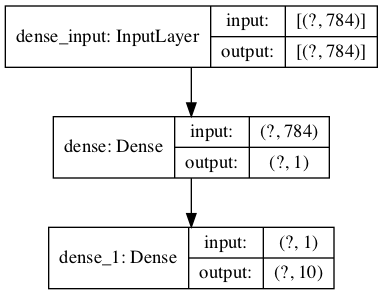

In [41]:
# Plot a graph of the model
keras.utils.plot_model(model_1, "figures/mnist_model_1_1hnode.png", show_shapes=True)

In [12]:
# Model summary
model_1.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 1)                 785       
_________________________________________________________________
dense_1 (Dense)              (None, 10)                20        
Total params: 805
Trainable params: 805
Non-trainable params: 0
_________________________________________________________________


## Compile model

To make our network ready for training, we need to pick three more things, as part of "compilation" step:

* A loss function: the is how the network will be able to measure how good a job it is doing on its training data, and thus how it will be able to steer itself in the right direction.
* An optimizer: this is the mechanism through which the network will update itself based on the data it sees and its loss function.
* Metrics to monitor during training and testing. Here we will only care about accuracy (the fraction of the images that were correctly classified).

In [13]:
# Compile model
model_1.compile(loss='sparse_categorical_crossentropy', optimizer='rmsprop', metrics=['accuracy'])

## Train model

We are now ready to train our network, which in Keras is done via a call to the `fit` method of the network: 
we "fit" the model to its training data. We train the model for 30 epochs with batch size 32 (the default).

In [14]:
# If loading previous model:
# model = model_1()
# model = load_model_1('results/keras_mnist_model_2.h5')

# Train the model
start_time = time.time()
history = model_1.fit(train_images, train_labels, validation_data=(val_images, val_labels), 
                      epochs=30)
# fit(train_images, train_labels, epochs=30,
#                     validation_data=(val_images, val_labels))
elapsed_time = time.time() - start_time
print('--------------------------')
print('Training time in seconds: ', round(elapsed_time,2))
print('--------------------------')

# Saving models locally after fitting
save_dir = "results/"
model_name = 'mnist_model_1.h5'
model_path = os.path.join(save_dir, model_name)
model_1.save(model_path)
print('Saved trained model at %s ' % model_path)
print('--------------------------')

Train on 55000 samples, validate on 5000 samples
Epoch 1/30
55000/55000 [==============================] - 3s 62us/sample - loss: 1.9612 - accuracy: 0.2236 - val_loss: 1.8292 - val_accuracy: 0.2822
Epoch 2/30
55000/55000 [==============================] - 3s 61us/sample - loss: 1.8108 - accuracy: 0.2961 - val_loss: 1.7554 - val_accuracy: 0.3192
Epoch 3/30
55000/55000 [==============================] - 3s 52us/sample - loss: 1.7606 - accuracy: 0.3187 - val_loss: 1.7152 - val_accuracy: 0.3384
Epoch 4/30
55000/55000 [==============================] - 4s 78us/sample - loss: 1.7309 - accuracy: 0.3283 - val_loss: 1.6901 - val_accuracy: 0.3436
Epoch 5/30
55000/55000 [==============================] - 3s 49us/sample - loss: 1.7117 - accuracy: 0.3363 - val_loss: 1.6732 - val_accuracy: 0.3432
Epoch 6/30
55000/55000 [==============================] - 3s 47us/sample - loss: 1.6968 - accuracy: 0.3423 - val_loss: 1.6629 - val_accuracy: 0.3530
Epoch 7/30
55000/55000 [==============================] -

## Test model

Evaluate the model on the test dataset.

In [15]:
test_loss, test_acc = model_1.evaluate(test_images, test_labels)

10000/10000 [==============================] - 0s 37us/sample - loss: 1.5850 - accuracy: 0.4333


In [16]:
print(f'test accuracy: {test_acc}, test loss: {test_loss}')

test accuracy: 0.4332999885082245, test loss: 1.5849745712280274


## Plot model performance
Assess accuracy and loss

In [17]:
history_dict = history.history
history_dict.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

**Figure 1: Learning curves for Model 1**

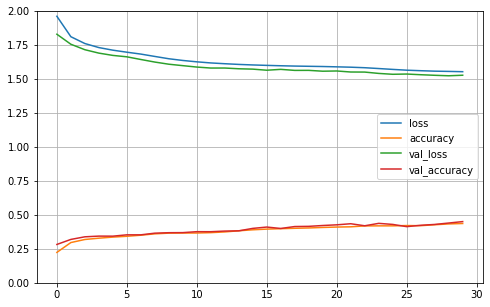

In [40]:
# Alternate code for accuracy and loss
# Plot learning curves for model
pd.DataFrame(history.history).plot(figsize=(8, 5))
plt.grid(True)
plt.gca().set_ylim(0, 2) # set the vertical range to [0-1]
plt.savefig("figures/learning_curves_model_1", tight_layout=False)
plt.show()

## Confusion matrix comparison

Evaluate prediction errors with Model 1

In [20]:
# Assign predicted classes
pred_classes = model_1.predict_classes(train_images)

In [21]:
# Create confusion matrix with values
conf_mx = confusion_matrix(train_labels,pred_classes)
conf_mx

array([[3014,  217,   29, 1088,  810,    0,    4,   39,  123,  120],
       [  30, 5594,  170,  152,   11,    0,   22,    4,  194,    2],
       [ 171, 1928, 2026,  462,   32,    0,  613,    8,  224,    6],
       [ 778, 1448,  160, 2249,  100,    0,    8,   91,  762,   42],
       [1617,   68,    5,  343, 2031,    0,    9,  368,   42,  824],
       [1440,  612,   74, 1986,  274,    0,   14,  129,  398,   60],
       [  31, 1057, 1242,  173,   11,    0, 2822,    0,   80,    1],
       [ 256,   36,    1,  106,  298,    0,    0, 4718,   22,  278],
       [ 438, 2537,   64, 1365,   91,    0,    1,   24,  855,   14],
       [ 392,   10,    0,   72,  750,    0,    0, 3256,   11,  963]])

**Figure 2: Confusion matrix for Model 1**

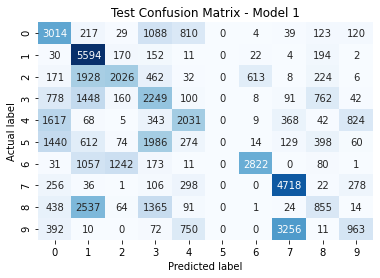

In [39]:
# Plot with values transposed to show actual versus predicted values
# m1_cm = confusion_matrix(train_labels, pred_classes)
m1_cm_plt=sns.heatmap(conf_mx, square=False, annot=True, fmt='d', cbar=False, cmap="Blues")
plt.xlabel('Predicted label')
plt.ylabel('Actual label')
plt.title("Test Confusion Matrix - Model 1")
plt.savefig("figures/confusion_matrix_errors_plot_model_1", tight_layout=False)
plt.show();

In [23]:
# Plot normalized confusion matrix
row_sums = conf_mx.sum(axis=1, keepdims=True)
norm_conf_mx = conf_mx / row_sums

**Figure 3: Normalized confusion matrix for Model 1**

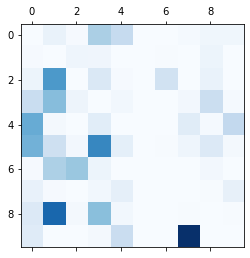

In [38]:
np.fill_diagonal(norm_conf_mx, 0)
plt.matshow(norm_conf_mx, cmap="Blues")
plt.savefig("figures/confusion_matrix_errors_plot_norm_model_1", tight_layout=False)
plt.show()

## Error analysis
No 5s were predicted, which is an issue considering the general balance of 0-9 classes in the data.

In [25]:
# Define function for plotting example digits
def plot_digits(instances, images_per_row=10, **options):
    size = 28
    images_per_row = min(len(instances), images_per_row)
    images = [instance.reshape(size,size) for instance in instances]
    n_rows = (len(instances) - 1) // images_per_row + 1
    row_images = []
    n_empty = n_rows * images_per_row - len(instances)
    images.append(np.zeros((size, size * n_empty)))
    for row in range(n_rows):
        rimages = images[row * images_per_row : (row + 1) * images_per_row]
        row_images.append(np.concatenate(rimages, axis=1))
    image = np.concatenate(row_images, axis=0)
    plt.imshow(image, cmap = 'binary', **options)
    plt.axis("off")

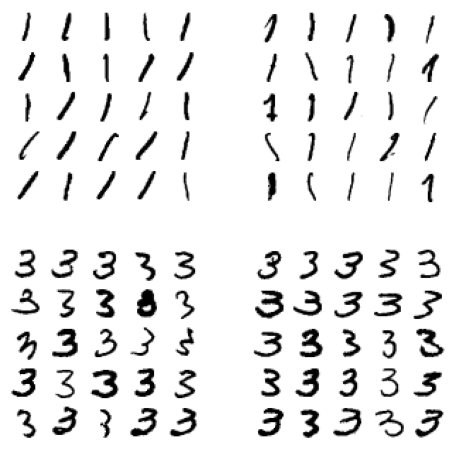

In [26]:
# Try some examples of mis-classes digits
# Upper left: 1s classified correctly as 1s
# Upper right: 1s classified as 3s
# Lower left: 3s classified as 1s
# Lower right: 3s classified correctly as 3sx

cl_a, cl_b = 1, 3
X_aa = train_images[(train_labels == cl_a) & (pred_classes == cl_a)]
X_ab = train_images[(train_labels == cl_a) & (pred_classes == cl_b)]
X_ba = train_images[(train_labels == cl_b) & (pred_classes == cl_a)]
X_bb = train_images[(train_labels == cl_b) & (pred_classes == cl_b)]

plt.figure(figsize=(8,8))
plt.subplot(221); plot_digits(X_aa[:25], images_per_row=5)
plt.subplot(222); plot_digits(X_ab[:25], images_per_row=5)
plt.subplot(223); plot_digits(X_ba[:25], images_per_row=5)
plt.subplot(224); plot_digits(X_bb[:25], images_per_row=5)
plt.savefig("error_analysis_digits_plot_EXP1_valid")
plt.show()

 ## Get the activation values of the hidden nodes
 
To get the activation values of the hidden nodes, we need to create a new model, `activation_model`, that takes the same input as our current model but outputs the activation value of the hidden layer, i.e. of the hidden node. Then use the `predict` function to get the activation values.

In [27]:
# Extract the outputs of the 2 layers
layer_outputs = [layer.output for layer in model_1.layers]

# Create a model that will return these outputs, given the model input
activation_model_1 = models.Model(inputs=model_1.input, outputs=layer_outputs)

# Print a description of the layers
print(f"There are {len(layer_outputs)} layers")
layer_outputs

There are 2 layers


[<tf.Tensor 'dense/Relu:0' shape=(None, 1) dtype=float32>,
 <tf.Tensor 'dense_1/Softmax:0' shape=(None, 10) dtype=float32>]

In [28]:
# Get the output of the hidden node for each of the 55000 training images
activations = activation_model_1.predict(train_images)
hidden_layer_activation = activations[0]
hidden_layer_activation.shape   #  hidden node has one activation value per training image

(55000, 1)

In [29]:
print(f"The maximum activation value of the hidden node is {hidden_layer_activation.max()}")

The maximum activation value of the hidden node is 65.29608154296875


In [30]:
# Output layer stats
np.set_printoptions(suppress = True)  # display probabilities as decimals and NOT in scientific notation
ouput_layer_activation = activations[1]
print(f"The output node has shape {ouput_layer_activation.shape}")
print(f"The output for the first image are {ouput_layer_activation[0].round(4)}")
print(f"The sum of the probabilities is (approximately) {ouput_layer_activation[0].sum()}")

The output node has shape (55000, 10)
The output for the first image are [0.0398 0.0001 0.     0.0031 0.0935 0.0083 0.     0.4896 0.0014 0.3642]
The sum of the probabilities is (approximately) 1.0


 ## Activation values boxplot 
 
We combine the activation values of the one hidden node  with the corresponding predicted classes into a DataFrame. We use both `matplotlib` and `seaborn` to create boxplots from the DataFrame.

In [31]:
# Create DataFrame of activation values and corresponding predicted class
boxplot_df = pd.DataFrame({'act_value':hidden_layer_activation.reshape(55000),
                           'pred_class':pred_classes})
boxplot_df.head()

,act_value,pred_class
0,-0.000000,7
1,3.236026,3
2,0.152618,7
3,5.412035,1
4,5.979540,1


In [32]:
# Value counts for boxplot
# Note missing class - 5
boxplot_df['pred_class'].value_counts() 

1    13507
7     8637
0     8167
3     7996
4     4408
2     3771
6     3493
8     2711
9     2310
Name: pred_class, dtype: int64

**Figure 4: Activation values boxplot**

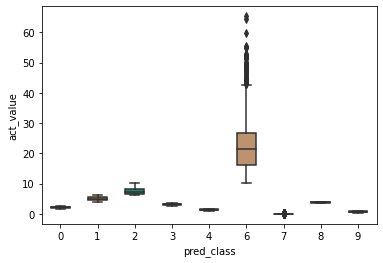

In [37]:
# Activation value boxplot
bplot = sns.boxplot(y='act_value', x='pred_class', 
                 data=boxplot_df, 
                 width=0.5,
                 palette="colorblind")
# bplot.savefig("act_values_model_1.png")

figure = bplot.get_figure()    
figure.savefig("figures/act_values_model_1.png", dpi=400)
# ax.set(ylim=(10, 40))

# EXPERIMENT  2:

This network will consist of 784 input nodes, a hidden layer with `2 nodes` and 10 output nodes (corresponding to the 10 digits). We use `mnist.load_data()` to get the 70,000 images divided into a set of 60,000 training images and 10,000 test images. We hold back 5,000 of the 60,000 training images for validation. 

For each of the 60,000 training images, the output of the two hidden nodes are plotted using a scatterplot. We color code the points according to which of the 10 classes the the output of the two nodes predicts. Ideally, just like in EXPERIMENT 1, the color clusters should have very little overlap.

## Build the network

Here our network consists of a sequence of two `Dense` layers, which are densely-connected (also called "fully-connected") neural layers. 

* The first `Dense` layer, the hidden layer, consists of `2 nodes`.

* The second (and last) layer is a 10-way "softmax" layer, which means it will return an array of 10 probability scores (summing to 1). Each  score will be the probability that the current digit image belongs to one of our 10 digit classes.

In [23]:
# Define model
model_2 = models.Sequential()
model_2.add(layers.Dense(2, activation='relu', input_shape=(28 * 28,)))
model_2.add(layers.Dense(10, activation='softmax'))   

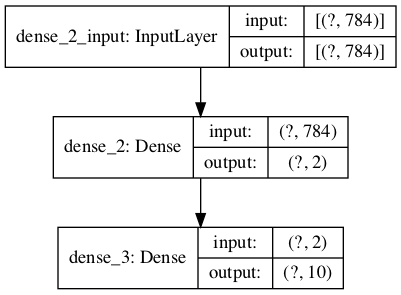

In [24]:
# Plot a graph of the model
keras.utils.plot_model(model_2, "figures/mnist_model_2_1hnode.png", show_shapes=True)

In [25]:
# Model summary
model_2.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_2 (Dense)              (None, 2)                 1570      
_________________________________________________________________
dense_3 (Dense)              (None, 10)                30        
Total params: 1,600
Trainable params: 1,600
Non-trainable params: 0
_________________________________________________________________


## Compile model

To make our network ready for training, we need to pick three more things, as part of "compilation" step:

* A loss function: the is how the network will be able to measure how good a job it is doing on its training data, and thus how it will be able to steer itself in the right direction.
* An optimizer: this is the mechanism through which the network will update itself based on the data it sees and its loss function.
* Metrics to monitor during training and testing. Here we will only care about accuracy (the fraction of the images that were correctly classified).

In [26]:
# Compile the model
model_2.compile(loss='sparse_categorical_crossentropy', optimizer='rmsprop', metrics=['accuracy'])

## Train model

We are now ready to train our network, which in Keras is done via a call to the `fit` method of the network: 
we "fit" the model to its training data. We train the model for 30 epochs with batch size 32 (the default).

In [27]:
# If loading previous model:
# model = model_2()
# model = load_model_2('results/mnist_model_2.h5')

# Train the model
start_time = time.time()
history = model_2.fit(train_images, train_labels, validation_data=(val_images, val_labels), 
                      epochs=30)
# fit(train_images, train_labels, epochs=30,
#                     validation_data=(val_images, val_labels))
elapsed_time = time.time() - start_time
print('--------------------------')
print('Training time in seconds: ', round(elapsed_time,2))
print('--------------------------')

# Saving models locally after fitting
save_dir = "results/"
model_name = 'mnist_model_2.h5'
model_path = os.path.join(save_dir, model_name)
model_2.save(model_path)
print('Saved trained model at %s ' % model_path)
print('--------------------------')

Train on 55000 samples, validate on 5000 samples
Epoch 1/30
55000/55000 [==============================] - 4s 66us/sample - loss: 1.5698 - accuracy: 0.4084 - val_loss: 1.2846 - val_accuracy: 0.5170
Epoch 2/30
55000/55000 [==============================] - 3s 56us/sample - loss: 1.2181 - accuracy: 0.5407 - val_loss: 1.1320 - val_accuracy: 0.5918
Epoch 3/30
55000/55000 [==============================] - 3s 58us/sample - loss: 1.1265 - accuracy: 0.5863 - val_loss: 1.0766 - val_accuracy: 0.6232
Epoch 4/30
55000/55000 [==============================] - 3s 59us/sample - loss: 1.0876 - accuracy: 0.6127 - val_loss: 1.0465 - val_accuracy: 0.6404
Epoch 5/30
55000/55000 [==============================] - 3s 60us/sample - loss: 1.0644 - accuracy: 0.6305 - val_loss: 1.0319 - val_accuracy: 0.6584
Epoch 6/30
55000/55000 [==============================] - 3s 56us/sample - loss: 1.0484 - accuracy: 0.6419 - val_loss: 1.0135 - val_accuracy: 0.6584
Epoch 7/30
55000/55000 [==============================] -

## Test model

Evaluate the model on the test dataset.

In [28]:
test_loss, test_acc = model_2.evaluate(test_images, test_labels)

10000/10000 [==============================] - 0s 35us/sample - loss: 0.9423 - accuracy: 0.7006


In [29]:
print(f'test accuracy: {test_acc}, test loss: {test_loss}')

test accuracy: 0.7006000280380249, test loss: 0.9423021728515625


## Plot model performance
Accuracy and loss

In [30]:
history_dict = history.history
history_dict.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

**Figure 5: Learning curves for Model 2**

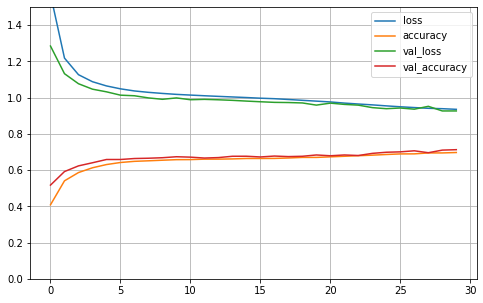

In [31]:
# Alternate code for accuracy and loss
# Plot learning curves for model
pd.DataFrame(history.history).plot(figsize=(8, 5))
plt.grid(True)
plt.gca().set_ylim(0, 1.5) # set the vertical range to [0-1]
plt.savefig("figures/learning_curves_model_2", tight_layout=False)
plt.show()

## Create confusion matrix with values

Confusion matrix is used to assess errors in prediction

In [32]:
# Assign predicted classes
pred_classes = model_2.predict_classes(train_images)

In [33]:
# Create confusion matrix with values
conf_mx = confusion_matrix(train_labels,pred_classes)
conf_mx

array([[4338,    7,  538,  449,    4,   46,    7,    0,   54,    1],
       [   3, 5695,   50,    7,  138,    4,   94,    2,  175,   11],
       [ 450,  127, 3490,  132,   26,   72,  875,    9,  281,    8],
       [ 439,   11,  221, 3344,   20,  706,    7,  297,  523,   70],
       [   4,  343,   47,    3, 4225,    5,   29,    5,  197,  449],
       [  93,   39,  387, 1546,   26, 1160,   42,  343, 1286,   65],
       [   7,  202,  433,    5,    5,    6, 4685,    0,   74,    0],
       [   5,   25,   17,  213,  128,  174,    3, 4249,  246,  655],
       [  16,  400,  183,  348,  251,  461,   51,  198, 3294,  187],
       [   6,   13,   14,   65,  721,   69,    3,  280,  179, 4104]])

**Figure 6: Confusion matrix for Model 2**

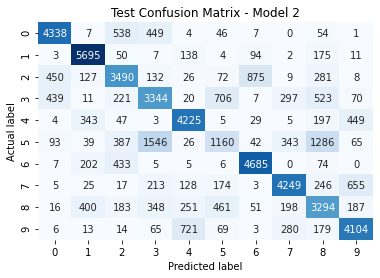

In [34]:
# Plot with values transposed to show actual versus predicted values
# m1_cm = confusion_matrix(train_labels, pred_classes)
m2_cm_plt=sns.heatmap(conf_mx, square=False, annot=True, fmt='d', cbar=False, cmap="Blues")
plt.xlabel('Predicted label')
plt.ylabel('Actual label')
plt.title("Test Confusion Matrix - Model 2")
plt.savefig("figures/confusion_matrix_errors_plot_model_2", tight_layout=False)
plt.show();

In [35]:
# Plot normalized confusion matrix
row_sums = conf_mx.sum(axis=1, keepdims=True)
norm_conf_mx = conf_mx / row_sums

**Figure 7: Normalized confusion matrix for Model 2**

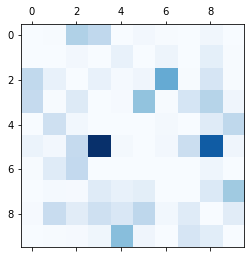

In [36]:
np.fill_diagonal(norm_conf_mx, 0)
plt.matshow(norm_conf_mx, cmap="Blues")
plt.savefig("figures/confusion_matrix_errors_plot__norm_model_1", tight_layout=False)
plt.show()

## Error analysis

In [37]:
# Define function for plotting example digits
def plot_digits(instances, images_per_row=10, **options):
    size = 28
    images_per_row = min(len(instances), images_per_row)
    images = [instance.reshape(size,size) for instance in instances]
    n_rows = (len(instances) - 1) // images_per_row + 1
    row_images = []
    n_empty = n_rows * images_per_row - len(instances)
    images.append(np.zeros((size, size * n_empty)))
    for row in range(n_rows):
        rimages = images[row * images_per_row : (row + 1) * images_per_row]
        row_images.append(np.concatenate(rimages, axis=1))
    image = np.concatenate(row_images, axis=0)
    plt.imshow(image, cmap = 'binary', **options)
    plt.axis("off")

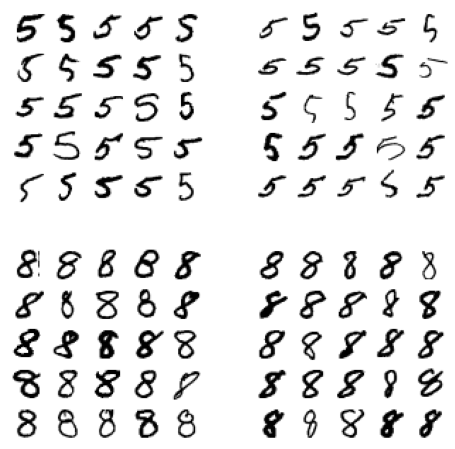

In [38]:
# Try some examples of mis-classes digits
# Upper left: 5s classified correctly as 5s
# Upper right: 5s classified as 8s
# Lower left: 8s classified as 5s
# Lower right: 8s classified correctly as 8s

cl_a, cl_b = 5, 8
X_aa = train_images[(train_labels == cl_a) & (pred_classes == cl_a)]
X_ab = train_images[(train_labels == cl_a) & (pred_classes == cl_b)]
X_ba = train_images[(train_labels == cl_b) & (pred_classes == cl_a)]
X_bb = train_images[(train_labels == cl_b) & (pred_classes == cl_b)]

plt.figure(figsize=(8,8))
plt.subplot(221); plot_digits(X_aa[:25], images_per_row=5)
plt.subplot(222); plot_digits(X_ab[:25], images_per_row=5)
plt.subplot(223); plot_digits(X_ba[:25], images_per_row=5)
plt.subplot(224); plot_digits(X_bb[:25], images_per_row=5)
plt.savefig("error_analysis_digits_plot_EXP1_valid")
plt.show()

 # Get the activation values of the hidden nodes
 
 To get the activation values of the hidden nodes, we need to create a new model, `activation_model`, that takes the same input as our current model but outputs the activation value of the hidden layer, i.e. of the hidden node. Then use the `predict` function to get the activation values.

In [39]:
# Extract the outputs of the 2 layers
layer_outputs = [layer.output for layer in model_2.layers]

# Create a model that will return these outputs, given the model input
activation_model_2 = models.Model(inputs=model_2.input, outputs=layer_outputs)

print(f"There are {len(layer_outputs)} layers")
layer_outputs # description of the layers

There are 2 layers


[<tf.Tensor 'dense_2/Relu:0' shape=(None, 2) dtype=float32>,
 <tf.Tensor 'dense_3/Softmax:0' shape=(None, 10) dtype=float32>]

In [40]:
# Get the output of the hidden node for each of the 55000 training images
activations = activation_model_2.predict(train_images)
hidden_layer_activation = activations[0]
hidden_layer_activation.shape   #  2 hidden node each has one activation value per training image

(55000, 2)

In [41]:
hidden_node1_activation = hidden_layer_activation[:,0] # get activation values of the first hidden node
hidden_node2_activation = hidden_layer_activation[:,1] # get activation values of the second hidden node

print(f"The maximum activation value of the first hidden node is {hidden_node1_activation.max()}")
print(f"The maximum activation value of the second hidden node is {hidden_node2_activation.max()}")

The maximum activation value of the first hidden node is 39.530494689941406
The maximum activation value of the second hidden node is 33.32828903198242


In [42]:
# Output layer stats
np.set_printoptions(suppress = True)  # display probabilities as decimals and NOT in scientific notation
ouput_layer_activation = activations[1]
print(f"The output node has shape {ouput_layer_activation.shape}")
print(f"The output for the first image are {ouput_layer_activation[0].round(4)}")
print(f"The sum of the probabilities is (approximately) {ouput_layer_activation[0].sum()}")

The output node has shape (55000, 10)
The output for the first image are [0.     0.     0.     0.0242 0.     0.0106 0.     0.9463 0.0002 0.0186]
The sum of the probabilities is (approximately) 1.0


# Activation values scatterplots
 
 We combine the activation values of the two hidden nodes together with the corresponding predicted classes into a DataFrame. We use both `matplotlib` and `seaborn` to create boxplots from the DataFrame.

In [43]:
scatterPlot_df =  pd.DataFrame({'act_value_h1':hidden_node1_activation,
                                'act_value_h2':hidden_node2_activation,
                                'pred_class':pred_classes})
scatterPlot_df.head()

,act_value_h1,act_value_h2,pred_class
0,15.107007,12.968557,7
1,7.321884,3.538808,3
2,5.511035,9.155907,9
3,0.206997,-0.000000,6
4,-0.000000,1.498670,1


**Figure 8: Activation values scatterplot for Model 2**

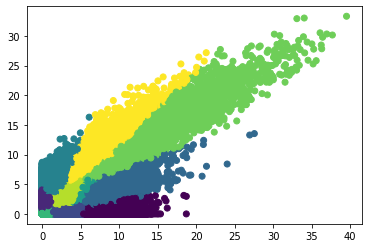

In [44]:
# plt.legend(loc='upper left', prop={'size':6}, bbox_to_anchor=(1,1),ncol=1)
plt.scatter(scatterPlot_df.act_value_h1, 
            scatterPlot_df.act_value_h2, 
            c=scatterPlot_df.pred_class,
            label=scatterPlot_df.pred_class)

plt.savefig("figures/act_values_model_2", tight_layout=False)

plt.show()

**Figure 9: Grouped activation values for Model 2**

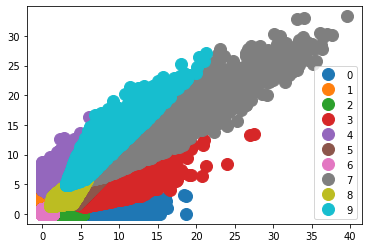

In [45]:
# Scatterplot grouped by predicted class
groups = scatterPlot_df.groupby('pred_class')

# Plot
fig, ax = plt.subplots()
ax.margins(0.05) # Optional, just adds 5% padding to the autoscaling
for name, group in groups:
    ax.plot(group.act_value_h1, group.act_value_h2, marker='o', linestyle='', ms=12, label=name)
ax.legend()

plt.savefig("figures/act_values_grouped_model_2", tight_layout=False)

plt.show()

# EXPERIMENT  3:

We want to select the *best* `DNN` model subject to certain restrictions on `hyperparameters`:
* The number of hidden layers will be one (network depth). 
* The number of nodes will be XXX (network width).

We will use `sklearn.grid_search.GridSearchCV` to find the `best` number of neurons for the hidden layer.

As before we will need 784 input nodes and 10 output nodes (corresponding to the 10 digits). We use `mnist.load_data()` to get the 70,000 images divided into a set of 60,000 training images and 10,000 test images. We hold back 5,000 of the 60,000 training images for validation. 

In [69]:
# Define a function to create a DNN with a given number of hidden layers and a fixed given number 
# of nodes per hidden layer
def build_model(n_hidden=1, n_neurons=2, learning_rate=0.001, input_shape=(28 * 28,)):
    model = models.Sequential()
    model.add(layers.InputLayer(input_shape=input_shape))
    for layer in range(n_hidden):
        model.add(keras.layers.Dense(n_neurons, activation="relu"))
    model.add(layers.Dense(10, activation='softmax'))
    optimizer = keras.optimizers.RMSprop(lr=learning_rate)
    model.compile(loss='sparse_categorical_crossentropy', optimizer=optimizer,  metrics=['accuracy'])
    return model

In [ ]:
# Define a second model that takes a tuple `(n1,n2...)`, where the number of coordinates is the 
# number of `hidden layers` with `n1` nodes in the first hidden layer, `n2` nodes in the second, etc.
def build_model2(n_neurons=(2,3), learning_rate=0.001, input_shape=(28 * 28,)):
    model = models.Sequential()
    model.add(layers.InputLayer(input_shape=input_shape))
    for layer in range(len(n_neurons)):
        model.add(keras.layers.Dense(n_neurons[layer], activation="relu"))
    model.add(layers.Dense(10, activation='softmax'))
    optimizer = keras.optimizers.RMSprop(lr=learning_rate)
    model.compile(loss='sparse_categorical_crossentropy', optimizer=optimizer,  metrics=['accuracy'])
    return model

In [70]:
# Create a `KerasClassifier` object, the class is an implementation of the scikit-learn classifier API for Keras. 
# It is actually a thin wrapper around the model that is built using our `build_model` function.
keras_clf = KerasClassifier(build_model)

## Hyperparameter tuning with grid search: range of neurons
Testing a range of neurons: 100, 900, 50 (100 to 900 in increments of 50)

```python
param_grid = {'n_neurons': range(100,900,50)}
param_grid
```

In [75]:
param_grid = {'n_neurons': range(100,900,50)}
param_grid

{'n_neurons': range(100, 900, 50)}

In [76]:
# Run grid search
grid_cv = GridSearchCV(estimator=keras_clf, param_grid=param_grid,cv=3,verbose = 2)
grid_cv.fit(train_images, train_labels, epochs=30,
                  validation_data=(val_images, val_labels),
                  callbacks=[keras.callbacks.EarlyStopping(patience=2)])

Fitting 3 folds for each of 16 candidates, totalling 48 fits
[CV] n_neurons=100 ...................................................


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Train on 36666 samples, validate on 5000 samples
Epoch 1/30
36666/36666 [==============================] - 6s 154us/sample - loss: 0.3270 - accuracy: 0.9073 - val_loss: 0.1802 - val_accuracy: 0.9482
Epoch 2/30
36666/36666 [==============================] - 6s 155us/sample - loss: 0.1643 - accuracy: 0.9518 - val_loss: 0.1352 - val_accuracy: 0.9592
Epoch 3/30
36666/36666 [==============================] - 5s 144us/sample - loss: 0.1191 - accuracy: 0.9646 - val_loss: 0.1180 - val_accuracy: 0.9652
Epoch 4/30
36666/36666 [==============================] - 5s 144us/sample - loss: 0.0961 - accuracy: 0.9724 - val_loss: 0.1064 - val_accuracy: 0.9696
Epoch 5/30
36666/36666 [==============================] - 5s 142us/sample - loss: 0.0808 - accuracy: 0.9764 - val_loss: 0.1057 - val_accuracy: 0.9712
Epoch 6/30
36666/36666 [==============================] - 5s 144us/sample - loss: 0.0685 - accuracy: 0.9801 - val_loss: 0.1117 - val_accuracy: 0.9660
Epoch 7/30
36666/36666 [===========================

[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   49.3s remaining:    0.0s


Train on 36667 samples, validate on 5000 samples
Epoch 1/30
36667/36667 [==============================] - 5s 149us/sample - loss: 0.3250 - accuracy: 0.9089 - val_loss: 0.1825 - val_accuracy: 0.9482
Epoch 2/30
36667/36667 [==============================] - 5s 138us/sample - loss: 0.1620 - accuracy: 0.9530 - val_loss: 0.1378 - val_accuracy: 0.9618
Epoch 3/30
36667/36667 [==============================] - 5s 139us/sample - loss: 0.1196 - accuracy: 0.9651 - val_loss: 0.1174 - val_accuracy: 0.9680
Epoch 4/30
36667/36667 [==============================] - 5s 139us/sample - loss: 0.0957 - accuracy: 0.9720 - val_loss: 0.1143 - val_accuracy: 0.9654
Epoch 5/30
36667/36667 [==============================] - 5s 142us/sample - loss: 0.0795 - accuracy: 0.9763 - val_loss: 0.1055 - val_accuracy: 0.9704
Epoch 6/30
36667/36667 [==============================] - 5s 145us/sample - loss: 0.0673 - accuracy: 0.9805 - val_loss: 0.1056 - val_accuracy: 0.9698
Epoch 7/30
18333/18333 [===========================

18334/18334 [==============================] - 1s 55us/sample - loss: 0.1255 - accuracy: 0.9706
[CV] .................................... n_neurons=300, total= 1.0min
[CV] n_neurons=300 ...................................................
Train on 36667 samples, validate on 5000 samples
Epoch 1/30
36667/36667 [==============================] - 9s 238us/sample - loss: 0.2715 - accuracy: 0.9213 - val_loss: 0.1375 - val_accuracy: 0.9602
Epoch 2/30
36667/36667 [==============================] - 8s 224us/sample - loss: 0.1220 - accuracy: 0.9640 - val_loss: 0.1106 - val_accuracy: 0.9676
Epoch 3/30
36667/36667 [==============================] - 8s 221us/sample - loss: 0.0846 - accuracy: 0.9754 - val_loss: 0.0965 - val_accuracy: 0.9734
Epoch 4/30
36667/36667 [==============================] - 8s 229us/sample - loss: 0.0628 - accuracy: 0.9817 - val_loss: 0.0941 - val_accuracy: 0.9726
Epoch 5/30
36667/36667 [==============================] - 8s 224us/sample - loss: 0.0476 - accuracy: 0.9862 - val

Epoch 3/30
36667/36667 [==============================] - 9s 256us/sample - loss: 0.0756 - accuracy: 0.9776 - val_loss: 0.0961 - val_accuracy: 0.9724
Epoch 4/30
36667/36667 [==============================] - 9s 243us/sample - loss: 0.0573 - accuracy: 0.9828 - val_loss: 0.0833 - val_accuracy: 0.9750
Epoch 5/30
36667/36667 [==============================] - 9s 243us/sample - loss: 0.0441 - accuracy: 0.9873 - val_loss: 0.0843 - val_accuracy: 0.9760
Epoch 6/30
36667/36667 [==============================] - 9s 250us/sample - loss: 0.0340 - accuracy: 0.9898 - val_loss: 0.0826 - val_accuracy: 0.9786
Epoch 7/30
36667/36667 [==============================] - 9s 257us/sample - loss: 0.0255 - accuracy: 0.9924 - val_loss: 0.0913 - val_accuracy: 0.9766
Epoch 8/30
18333/18333 [==============================] - 1s 58us/sample - loss: 0.1228 - accuracy: 0.9750
[CV] .................................... n_neurons=400, total= 1.4min
[CV] n_neurons=400 ...................................................
T

Epoch 3/30
36667/36667 [==============================] - 12s 326us/sample - loss: 0.0735 - accuracy: 0.9783 - val_loss: 0.1006 - val_accuracy: 0.9718
Epoch 4/30
36667/36667 [==============================] - 12s 320us/sample - loss: 0.0542 - accuracy: 0.9839 - val_loss: 0.0825 - val_accuracy: 0.9758
Epoch 5/30
36667/36667 [==============================] - 11s 302us/sample - loss: 0.0391 - accuracy: 0.9885 - val_loss: 0.0922 - val_accuracy: 0.9768
Epoch 6/30
18333/18333 [==============================] - 1s 66us/sample - loss: 0.1232 - accuracy: 0.9737
[CV] .................................... n_neurons=500, total= 1.2min
[CV] n_neurons=500 ...................................................
Train on 36667 samples, validate on 5000 samples
Epoch 1/30
36667/36667 [==============================] - 14s 377us/sample - loss: 0.2485 - accuracy: 0.9258 - val_loss: 0.1294 - val_accuracy: 0.9624
Epoch 2/30
36667/36667 [==============================] - 12s 331us/sample - loss: 0.1090 - accura

Epoch 2/30
36667/36667 [==============================] - 12s 340us/sample - loss: 0.1016 - accuracy: 0.9702 - val_loss: 0.1180 - val_accuracy: 0.9632
Epoch 3/30
36667/36667 [==============================] - 12s 340us/sample - loss: 0.0707 - accuracy: 0.9796 - val_loss: 0.0908 - val_accuracy: 0.9756
Epoch 4/30
36667/36667 [==============================] - 14s 374us/sample - loss: 0.0505 - accuracy: 0.9855 - val_loss: 0.0908 - val_accuracy: 0.9760
Epoch 5/30
36667/36667 [==============================] - 15s 409us/sample - loss: 0.0385 - accuracy: 0.9894 - val_loss: 0.0892 - val_accuracy: 0.9782
Epoch 6/30
36667/36667 [==============================] - 16s 428us/sample - loss: 0.0308 - accuracy: 0.9913 - val_loss: 0.0907 - val_accuracy: 0.9772
Epoch 7/30
18333/18333 [==============================] - 1s 72us/sample - loss: 0.1182 - accuracy: 0.9749
[CV] .................................... n_neurons=600, total= 1.7min
[CV] n_neurons=650 ................................................

18333/18333 [==============================] - 1s 75us/sample - loss: 0.1322 - accuracy: 0.9770
[CV] .................................... n_neurons=700, total= 2.4min
[CV] n_neurons=750 ...................................................
Train on 36666 samples, validate on 5000 samples
Epoch 1/30
36666/36666 [==============================] - 15s 406us/sample - loss: 0.2339 - accuracy: 0.9296 - val_loss: 0.1298 - val_accuracy: 0.9632
Epoch 2/30
36666/36666 [==============================] - 14s 378us/sample - loss: 0.1044 - accuracy: 0.9695 - val_loss: 0.0947 - val_accuracy: 0.9738
Epoch 3/30
36666/36666 [==============================] - 14s 374us/sample - loss: 0.0709 - accuracy: 0.9793 - val_loss: 0.0962 - val_accuracy: 0.9728
Epoch 4/30
18334/18334 [==============================] - 1s 77us/sample - loss: 0.1248 - accuracy: 0.9723
[CV] .................................... n_neurons=750, total=  59.8s
[CV] n_neurons=750 ...................................................
Train on 36

Epoch 6/30
18334/18334 [==============================] - 2s 115us/sample - loss: 0.1525 - accuracy: 0.9702
[CV] .................................... n_neurons=850, total= 2.4min
[CV] n_neurons=850 ...................................................
Train on 36667 samples, validate on 5000 samples
Epoch 1/30
36667/36667 [==============================] - 20s 538us/sample - loss: 0.2391 - accuracy: 0.9288 - val_loss: 0.1136 - val_accuracy: 0.9660
Epoch 2/30
36667/36667 [==============================] - 19s 531us/sample - loss: 0.1021 - accuracy: 0.9705 - val_loss: 0.0986 - val_accuracy: 0.9730
Epoch 3/30
36667/36667 [==============================] - 18s 500us/sample - loss: 0.0679 - accuracy: 0.9807 - val_loss: 0.0873 - val_accuracy: 0.9764
Epoch 4/30
36667/36667 [==============================] - 17s 477us/sample - loss: 0.0525 - accuracy: 0.9844 - val_loss: 0.1024 - val_accuracy: 0.9748
Epoch 5/30
18333/18333 [==============================] - 2s 96us/sample - loss: 0.1218 - accurac

[Parallel(n_jobs=1)]: Done  48 out of  48 | elapsed: 105.2min finished


Train on 55000 samples, validate on 5000 samples
Epoch 1/30
55000/55000 [==============================] - 23s 417us/sample - loss: 0.2031 - accuracy: 0.9398 - val_loss: 0.1027 - val_accuracy: 0.9712
Epoch 2/30
55000/55000 [==============================] - 23s 417us/sample - loss: 0.0901 - accuracy: 0.9744 - val_loss: 0.0983 - val_accuracy: 0.9702
Epoch 3/30
55000/55000 [==============================] - 24s 433us/sample - loss: 0.0633 - accuracy: 0.9824 - val_loss: 0.0915 - val_accuracy: 0.9772
Epoch 4/30
55000/55000 [==============================] - 24s 429us/sample - loss: 0.0499 - accuracy: 0.9862 - val_loss: 0.0826 - val_accuracy: 0.9774
Epoch 5/30
55000/55000 [==============================] - 22s 399us/sample - loss: 0.0395 - accuracy: 0.9889 - val_loss: 0.0891 - val_accuracy: 0.9778
Epoch 6/30
55000/55000 [==============================] - 27s 498us/sample - loss: 0.0304 - accuracy: 0.9922 - val_loss: 0.0909 - val_accuracy: 0.9778


GridSearchCV(cv=3, error_score=nan,
             estimator=<tensorflow.python.keras.wrappers.scikit_learn.KerasClassifier object at 0x1a40c165f8>,
             iid='deprecated', n_jobs=None,
             param_grid={'n_neurons': range(100, 900, 50)},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring=None, verbose=2)

In [77]:
# Evaluate the number of neurons that produced the best estimator
grid_cv.best_params_

{'n_neurons': 700}

In [78]:
# Results to compare the performance of the models
results = grid_cv.cv_results_
results

{'mean_fit_time': array([ 41.12912011, 630.86422348,  77.88898277,  59.92755167,
         57.86564732,  61.81225936,  74.93807228,  96.85294294,
         72.20501359, 104.03751699, 270.95088029,  93.30652022,
        109.73006535, 112.4122289 , 115.95351354, 103.50072034]),
 'std_fit_time': array([  5.27420829, 832.59516307,  31.84032017,  12.41713136,
          8.92254138,  12.39513237,  10.10858184,  16.88657514,
          3.16720018,   7.74588704, 274.00334358,  25.66947123,
         25.42976736,  49.70870004,  26.68701655,  30.01017496]),
 'mean_score_time': array([0.77198696, 0.76900085, 1.05369322, 1.03885627, 1.02395908,
        1.09872262, 1.092134  , 1.30000401, 1.45409743, 1.26738   ,
        1.45491107, 1.57188773, 1.40401681, 1.68524734, 1.71294999,
        1.89409161]),
 'std_score_time': array([0.01318589, 0.05691487, 0.19421153, 0.0942548 , 0.01745575,
        0.03468624, 0.02306103, 0.0988736 , 0.27488174, 0.09061485,
        0.13951719, 0.01138051, 0.02879567, 0.372779

In [79]:
results['params'], results['rank_test_score']

([{'n_neurons': 100},
  {'n_neurons': 150},
  {'n_neurons': 200},
  {'n_neurons': 250},
  {'n_neurons': 300},
  {'n_neurons': 350},
  {'n_neurons': 400},
  {'n_neurons': 450},
  {'n_neurons': 500},
  {'n_neurons': 550},
  {'n_neurons': 600},
  {'n_neurons': 650},
  {'n_neurons': 700},
  {'n_neurons': 750},
  {'n_neurons': 800},
  {'n_neurons': 850}],
 array([16, 13, 10,  7, 15, 14,  3,  5,  8,  6,  9,  4,  1,  2, 11, 12],
       dtype=int32))

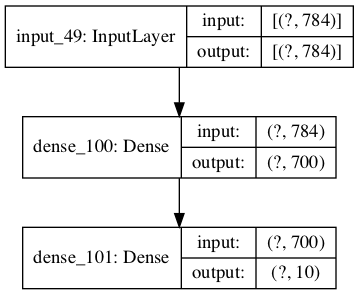

In [80]:
# Assign the best model and plot
best_model = grid_cv.best_estimator_.model
keras.utils.plot_model(best_model, "figures/mnist_model_3_1hnode.png", show_shapes=True)

In [81]:
# Evaluate best model with test data
best_model.evaluate(test_images, test_labels)

10000/10000 [==============================] - 1s 123us/sample - loss: 0.0901 - accuracy: 0.9796


[0.0901317909641477, 0.9796]

In [82]:
# Save model for re-use
save_dir = "results/"
model_name = 'exp_3_best_model.h5'
model_path = os.path.join(save_dir, model_name)
best_model.save(model_path)
print('Saved trained model at %s ' % model_path)
print('--------------------------')
# best_model.save("mnist_model_best.h5")

Saved trained model at results/exp_3_best_model.h5 
--------------------------


## Build the network

* Sequence of two `Dense` layers, which are densely-connected (also called "fully-connected") neural layers. 

* The first `Dense` layer, the hidden layer, consists of `700 nodes` with reLu activation, identified via grid search.

* The second (and last) layer is a 10-way "softmax" layer, which means it will return an array of 10 probability scores (summing to 1). Each  score will be the probability that the current digit image belongs to one of our 10 digit classes.

In [83]:
model_3 = models.Sequential()
model_3.add(layers.Dense(700, activation='relu', input_shape=(28 * 28,)))
model_3.add(layers.Dense(10, activation='softmax'))   

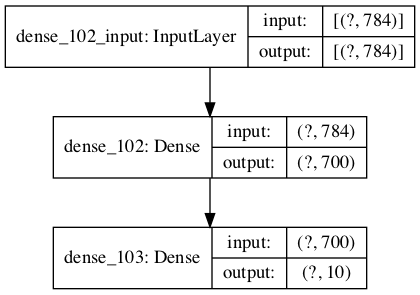

In [84]:
keras.utils.plot_model(model_3, "figures/mnist_model_3_1hnode.png", show_shapes=True)

## Compile model

To make our network ready for training, we need to pick three more things, as part of "compilation" step:

* A loss function: the is how the network will be able to measure how good a job it is doing on its training data, and thus how it will be able to steer itself in the right direction.
* An optimizer: this is the mechanism through which the network will update itself based on the data it sees and its loss function.
* Metrics to monitor during training and testing. Here we will only care about accuracy (the fraction of the images that were correctly classified).

In [85]:
# Compile the model
model_3.compile(loss='sparse_categorical_crossentropy', optimizer='rmsprop', metrics=['accuracy'])

## Train model

We are now ready to train our network, which in Keras is done via a call to the `fit` method of the network: 
we "fit" the model to its training data. We train the model for 30 epochs with batch size 32 (the default).

In [86]:
# If loading previous model:
# # model = model_2()
# model_3 = load_model_3('results/exp_3_best_model.h5')

# Train the model
start_time = time.time()
history = model_3.fit(train_images, train_labels, epochs=30,
                    validation_data=(val_images, val_labels),
                    callbacks=[keras.callbacks.EarlyStopping(patience=10)])
elapsed_time = time.time() - start_time
print('--------------------------')
print('Training time in seconds: ', round(elapsed_time,2))
print('--------------------------')

# Saving models locally after fitting
save_dir = "results/"
model_name = 'mnist_model_3.h5'
model_path = os.path.join(save_dir, model_name)
model_3.save(model_path)
print('Saved trained model at %s ' % model_path)
print('--------------------------')

Train on 55000 samples, validate on 5000 samples
Epoch 1/30
55000/55000 [==============================] - 27s 493us/sample - loss: 0.2042 - accuracy: 0.9398 - val_loss: 0.1131 - val_accuracy: 0.9672
Epoch 2/30
55000/55000 [==============================] - 26s 464us/sample - loss: 0.0933 - accuracy: 0.9730 - val_loss: 0.0821 - val_accuracy: 0.9770
Epoch 3/30
55000/55000 [==============================] - 24s 439us/sample - loss: 0.0653 - accuracy: 0.9819 - val_loss: 0.0862 - val_accuracy: 0.9790
Epoch 4/30
55000/55000 [==============================] - 22s 408us/sample - loss: 0.0515 - accuracy: 0.9859 - val_loss: 0.0793 - val_accuracy: 0.9796
Epoch 5/30
55000/55000 [==============================] - 23s 412us/sample - loss: 0.0401 - accuracy: 0.9893 - val_loss: 0.0875 - val_accuracy: 0.9800
Epoch 6/30
55000/55000 [==============================] - 22s 407us/sample - loss: 0.0313 - accuracy: 0.9913 - val_loss: 0.0828 - val_accuracy: 0.9818
Epoch 7/30
55000/55000 [=====================

## Test model

Evaluate the model on the test dataset.

In [87]:
test_loss, test_acc = model_3.evaluate(test_images, test_labels)

10000/10000 [==============================] - 1s 112us/sample - loss: 0.1188 - accuracy: 0.9820


In [88]:
print(f'test accuracy: {test_acc}, test loss: {test_loss}')

test accuracy: 0.9819999933242798, test loss: 0.11882708966166242


## Plot model performance
Accuracy and loss

In [90]:
history_dict = history.history
history_dict.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

**Figure 10: Learning curves for Model 3**

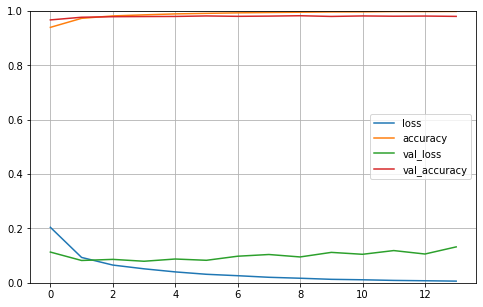

In [91]:
# Alternate code for accuracy and loss
# Plot learning curves for model
pd.DataFrame(history.history).plot(figsize=(8, 5))
plt.grid(True)
plt.gca().set_ylim(0, 1) # set the vertical range to [0-1]
plt.savefig("figures/learning_curves_model_3", tight_layout=False)
plt.show()

## Hyperparameter tuning and comparison

* Sequence of two `Dense` layers, which are densely-connected (also called "fully-connected") neural layers. 

* The first `Dense` layer, the hidden layer, consists of `700 nodes` (identified via grid search) with sigmoid activation.

* The second (and last) layer is a 10-way "softmax" layer, which means it will return an array of 10 probability scores (summing to 1). Each  score will be the probability that the current digit image belongs to one of our 10 digit classes.

In [92]:
model_3_a = models.Sequential()
model_3_a.add(layers.Dense(700, activation='sigmoid', input_shape=(28 * 28,)))
model_3_a.add(layers.Dense(10, activation='softmax'))   

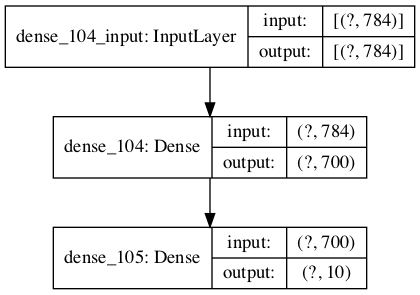

In [93]:
keras.utils.plot_model(model_3_a, show_shapes=True)

## Compile model

To make our network ready for training, we need to pick three more things, as part of "compilation" step:

* A loss function: the is how the network will be able to measure how good a job it is doing on its training data, and thus how it will be able to steer itself in the right direction.
* An optimizer: this is the mechanism through which the network will update itself based on the data it sees and its loss function. In this case, Adam is used as a comparison to rmsprop in the previous model, to see if adding momentum leads to performance improvement.
* Metrics to monitor during training and testing. Here we will only care about accuracy (the fraction of the images that were correctly classified).

In [94]:
# Compile the model
model_3_a.compile(loss='sparse_categorical_crossentropy', optimizer='Adam', metrics=['accuracy'])

## Train model

We are now ready to train our network, which in Keras is done via a call to the `fit` method of the network: 
we "fit" the model to its training data. We train the model for 30 epochs with batch size 32 (the default).

In [95]:
# If loading previous model:
# model = model_2()
# model = load_model_3('results/keras_mnist_model_3.h5')

# Train the model
start_time = time.time()
history = model_3_a.fit(train_images, train_labels, epochs=30,
                    validation_data=(val_images, val_labels),
                    callbacks=[keras.callbacks.EarlyStopping(patience=10)])
elapsed_time = time.time() - start_time
print('--------------------------')
print('Training time in seconds: ', round(elapsed_time,2))
print('--------------------------')

# Saving models locally after fitting
save_dir = "results/"
model_name = 'mnist_model_3_a.h5'
model_path = os.path.join(save_dir, model_name)
model_3_a.save(model_path)
print('Saved trained model at %s ' % model_path)
print('--------------------------')

Train on 55000 samples, validate on 5000 samples
Epoch 1/30
55000/55000 [==============================] - 24s 440us/sample - loss: 0.3475 - accuracy: 0.9010 - val_loss: 0.2081 - val_accuracy: 0.9406
Epoch 2/30
55000/55000 [==============================] - 22s 408us/sample - loss: 0.1784 - accuracy: 0.9468 - val_loss: 0.1369 - val_accuracy: 0.9642
Epoch 3/30
55000/55000 [==============================] - 22s 408us/sample - loss: 0.1156 - accuracy: 0.9656 - val_loss: 0.0982 - val_accuracy: 0.9720
Epoch 4/30
55000/55000 [==============================] - 23s 418us/sample - loss: 0.0810 - accuracy: 0.9757 - val_loss: 0.0823 - val_accuracy: 0.9760
Epoch 5/30
55000/55000 [==============================] - 23s 412us/sample - loss: 0.0577 - accuracy: 0.9824 - val_loss: 0.0748 - val_accuracy: 0.9766
Epoch 6/30
55000/55000 [==============================] - 23s 421us/sample - loss: 0.0422 - accuracy: 0.9870 - val_loss: 0.0682 - val_accuracy: 0.9804
Epoch 7/30
55000/55000 [=====================

## Test model

Evaluate the model on the test dataset.

In [96]:
test_loss, test_acc = model_3_a.evaluate(test_images, test_labels)

10000/10000 [==============================] - 1s 126us/sample - loss: 0.0776 - accuracy: 0.9818


In [97]:
print(f'test accuracy: {test_acc}, test loss: {test_loss}')

test accuracy: 0.9818000197410583, test loss: 0.07755896054905373


## Plot model performance
Accuracy and loss

In [98]:
history_dict = history.history
history_dict.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

**Figure 11: Learning curves for Model 3a**

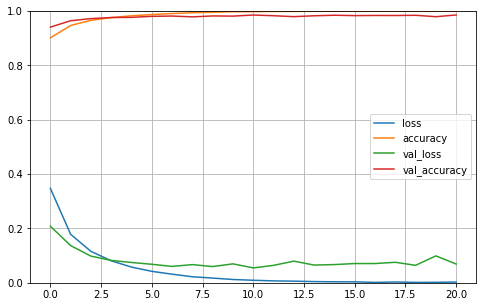

In [99]:
# Alternate code for accuracy and loss
# Plot learning curves for model
pd.DataFrame(history.history).plot(figsize=(8, 5))
plt.grid(True)
plt.gca().set_ylim(0, 1) # set the vertical range to [0-1]
plt.savefig("figures/learning_curves_model_3_a", tight_layout=False)
plt.show()

## Confusion matrix
Create a confusion matrix to assess prediction errors. Compare Model 3 (reLu activation and rmsprop optimizer) with Model 3a (sigmoid activation and Adam optimizer).


In [100]:
# Assign predicted classes
pred_classes = model_3.predict_classes(train_images)

In [101]:
# Create confusion matrix with values
conf_mx = confusion_matrix(train_labels,pred_classes)
conf_mx

array([[5443,    0,    0,    0,    0,    0,    0,    0,    0,    1],
       [   0, 6163,    2,    0,    0,    0,    1,    3,    7,    3],
       [   0,    0, 5465,    0,    0,    0,    0,    5,    0,    0],
       [   0,    0,    0, 5635,    0,    0,    0,    0,    3,    0],
       [   0,    0,    0,    0, 5304,    0,    0,    1,    1,    1],
       [   0,    0,    0,    0,    0, 4987,    0,    0,    0,    0],
       [   2,    0,    0,    0,    0,    2, 5412,    0,    1,    0],
       [   0,    0,    0,    0,    0,    0,    0, 5715,    0,    0],
       [   0,    1,    0,    0,    0,    0,    0,    0, 5387,    1],
       [   0,    0,    0,    2,    2,    0,    0,    3,    1, 5446]])

**Figure 11: Confusion matrix for Model 3**

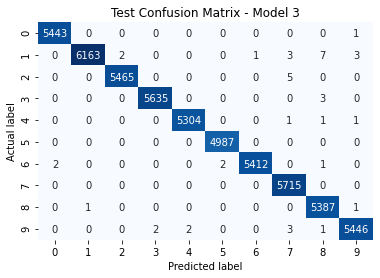

In [102]:
# Plot with values transposed to show actual versus predicted values
# m1_cm = confusion_matrix(train_labels, pred_classes)
m3_cm_plt=sns.heatmap(conf_mx, square=False, annot=True, fmt='d', cbar=False, cmap="Blues")
plt.xlabel('Predicted label')
plt.ylabel('Actual label')
plt.title("Test Confusion Matrix - Model 3")
plt.savefig("figures/confusion_matrix_errors_plot_model_3", tight_layout=False)
plt.show();

In [103]:
# Plot normalized confusion matrix
row_sums = conf_mx.sum(axis=1, keepdims=True)
norm_conf_mx = conf_mx / row_sums

**Figure 12: Normalized confusion matrix for Model 3**

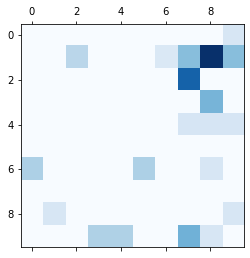

In [104]:
np.fill_diagonal(norm_conf_mx, 0)
plt.matshow(norm_conf_mx, cmap="Blues")
plt.savefig("figures/confusion_matrix_errors_plot_norm_model_3", tight_layout=False)
plt.show()

In [106]:
# Assign predicted classes
pred_classes = model_3_a.predict_classes(train_images)

In [107]:
# Create confusion matrix with values
conf_mx = confusion_matrix(train_labels,pred_classes)
conf_mx

array([[5444,    0,    0,    0,    0,    0,    0,    0,    0,    0],
       [   0, 6179,    0,    0,    0,    0,    0,    0,    0,    0],
       [   0,    0, 5470,    0,    0,    0,    0,    0,    0,    0],
       [   0,    0,    0, 5638,    0,    0,    0,    0,    0,    0],
       [   0,    0,    0,    0, 5307,    0,    0,    0,    0,    0],
       [   0,    0,    0,    0,    0, 4987,    0,    0,    0,    0],
       [   0,    0,    0,    0,    0,    0, 5417,    0,    0,    0],
       [   0,    0,    0,    0,    0,    0,    0, 5714,    0,    1],
       [   0,    0,    0,    0,    0,    0,    0,    0, 5389,    0],
       [   0,    0,    0,    0,    0,    0,    0,    0,    0, 5454]])

**Figure 13: Confusion matrix for Model 3a**

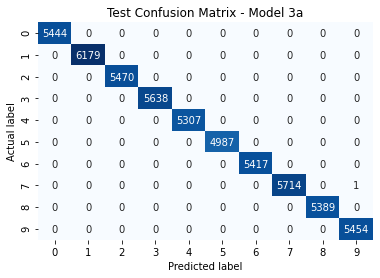

In [108]:
# Plot with values transposed to show actual versus predicted values
# m1_cm = confusion_matrix(train_labels, pred_classes)
m3_cm_plt=sns.heatmap(conf_mx, square=False, annot=True, fmt='d', cbar=False, cmap="Blues")
plt.xlabel('Predicted label')
plt.ylabel('Actual label')
plt.title("Test Confusion Matrix - Model 3a")
plt.savefig("figures/confusion_matrix_errors_plot_model_3a", tight_layout=False)
plt.show();

In [109]:
# Plot normalized confusion matrix
row_sums = conf_mx.sum(axis=1, keepdims=True)
norm_conf_mx = conf_mx / row_sums

**Figure 14: Normalized confusion matrix for Model 3a**

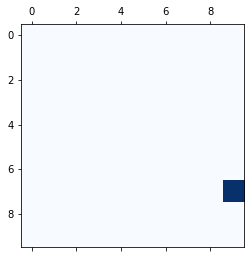

In [110]:
np.fill_diagonal(norm_conf_mx, 0)
plt.matshow(norm_conf_mx, cmap="Blues")
plt.savefig("figures/confusion_matrix_errors_plot_norm_model_3a", tight_layout=False)
plt.show()

## Error analysis

In [46]:
# Define function for plotting example digits
def plot_digits(instances, images_per_row=10, **options):
    size = 28
    images_per_row = min(len(instances), images_per_row)
    images = [instance.reshape(size,size) for instance in instances]
    n_rows = (len(instances) - 1) // images_per_row + 1
    row_images = []
    n_empty = n_rows * images_per_row - len(instances)
    images.append(np.zeros((size, size * n_empty)))
    for row in range(n_rows):
        rimages = images[row * images_per_row : (row + 1) * images_per_row]
        row_images.append(np.concatenate(rimages, axis=1))
    image = np.concatenate(row_images, axis=0)
    plt.imshow(image, cmap = 'binary', **options)
    plt.axis("off")

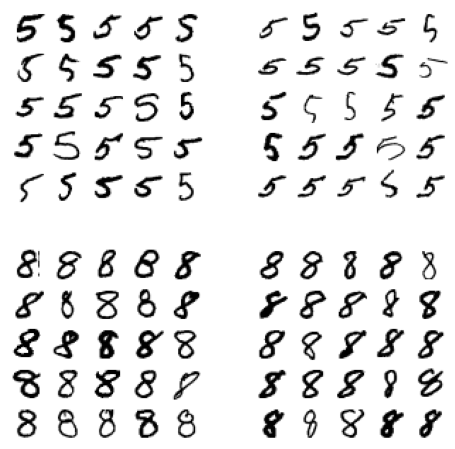

In [47]:
# Try some examples of mis-classes digits
# Upper left: 5s classified correctly as 5s
# Upper right: 5s classified as 8s
# Lower left: 8s classified as 5s
# Lower right: 8s classified correctly as 8s

cl_a, cl_b = 5, 8
X_aa = train_images[(train_labels == cl_a) & (pred_classes == cl_a)]
X_ab = train_images[(train_labels == cl_a) & (pred_classes == cl_b)]
X_ba = train_images[(train_labels == cl_b) & (pred_classes == cl_a)]
X_bb = train_images[(train_labels == cl_b) & (pred_classes == cl_b)]

plt.figure(figsize=(8,8))
plt.subplot(221); plot_digits(X_aa[:25], images_per_row=5)
plt.subplot(222); plot_digits(X_ab[:25], images_per_row=5)
plt.subplot(223); plot_digits(X_ba[:25], images_per_row=5)
plt.subplot(224); plot_digits(X_bb[:25], images_per_row=5)
plt.savefig("results/error_analysis_digits_plot_EXP3_valid")
plt.show()

# Experiment 4

We use PCA decomposition to reduce the number of dimensions of our training set of 28x28 dimensional MNIST images. By setting `n_components=0.95` we get the 154 principal components that contain 95% of the variance (information) in the training images. We transform the training images to reduce its dimensionality from 784 to 154. We also reduce the number of dimensions of 'best' model from Experiment 3 to 154 inputs nodes and train it on the new lower dimensional data. 

In [113]:
# Reduce dimensions to those containing 95% of the variance in the training images
pca = PCA(n_components=0.95)
train_images_red = pca.fit_transform(train_images)
val_images_red = pca.transform(val_images)
test_images_red = pca.transform(test_images)

In [114]:
# Evaluate shape of data with reduced dimensions
test_images_red.shape, train_images_red.shape, val_images_red.shape

((10000, 154), (55000, 154), (5000, 154))

## Build "best" network before dimension reduction
* Using the "best" model from Experiment 3, our baseline network consists of a sequence of two Dense layers, which are densely-connected (also called "fully-connected") neural layers.

* The first Dense layer, the hidden layer, consists of 600 nodes.

* The second (and last) layer is a 10-way "softmax" layer, which means it will return an array of 10 probability scores (summing to 1). Each score will be the probability that the current digit image belongs to one of our 10 digit classes.

In [116]:
# # If loading previous model:
# model = model_3()
# model_4 = load_model_3('results/mnist_model_3.h5')

model_4 = models.Sequential()
model_4.add(layers.Dense(700, activation='sigmoid', input_shape=(28 * 28,)))
model_4.add(layers.Dense(10, activation='softmax')) 

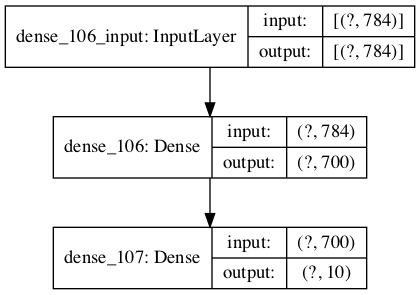

In [117]:
# Plot model
keras.utils.plot_model(model_4, "figures/mnist_model_4.png", show_shapes=True) # plot a graph of the model

In [118]:
model_4.summary()

Model: "sequential_54"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_106 (Dense)            (None, 700)               549500    
_________________________________________________________________
dense_107 (Dense)            (None, 10)                7010      
Total params: 556,510
Trainable params: 556,510
Non-trainable params: 0
_________________________________________________________________


## Compile model

To make our network ready for training, we need to pick three more things, as part of "compilation" step:

* A loss function: the is how the network will be able to measure how good a job it is doing on its training data, and thus how it will be able to steer itself in the right direction.
* An optimizer: this is the mechanism through which the network will update itself based on the data it sees and its loss function.
* Metrics to monitor during training and testing. Here we will only care about accuracy (the fraction of the images that were correctly classified).

In [119]:
# Compile the model
model_4.compile(loss='sparse_categorical_crossentropy', optimizer='Adam', metrics=['accuracy'])

## Train model

We are now ready to train our network, which in Keras is done via a call to the `fit` method of the network: 
we "fit" the model to its training data. We train the model for 30 epochs with batch size 32 (the default).

In [120]:
# If loading previous model:
# model = model_2()
# model = load_model_3('results/keras_mnist_model_3.h5')

# Train the model
start_time = time.time()
history = model_4.fit(train_images, train_labels, epochs=30,
                    validation_data=(val_images, val_labels),
                    callbacks=[keras.callbacks.EarlyStopping(patience=10)])
elapsed_time = time.time() - start_time
print('--------------------------')
print('Training time in seconds: ', round(elapsed_time,2))
print('--------------------------')

# Saving models locally after fitting
save_dir = "results/"
model_name = 'mnist_model_4.h5'
model_path = os.path.join(save_dir, model_name)
model_4.save(model_path)
print('Saved trained model at %s ' % model_path)
print('--------------------------')

Train on 55000 samples, validate on 5000 samples
Epoch 1/30
55000/55000 [==============================] - 26s 479us/sample - loss: 0.3431 - accuracy: 0.9017 - val_loss: 0.2053 - val_accuracy: 0.9390
Epoch 2/30
55000/55000 [==============================] - 23s 422us/sample - loss: 0.1796 - accuracy: 0.9465 - val_loss: 0.1476 - val_accuracy: 0.9572
Epoch 3/30
55000/55000 [==============================] - 24s 438us/sample - loss: 0.1166 - accuracy: 0.9651 - val_loss: 0.1052 - val_accuracy: 0.9690
Epoch 4/30
55000/55000 [==============================] - 24s 443us/sample - loss: 0.0812 - accuracy: 0.9755 - val_loss: 0.0874 - val_accuracy: 0.9732
Epoch 5/30
55000/55000 [==============================] - 24s 429us/sample - loss: 0.0585 - accuracy: 0.9822 - val_loss: 0.0737 - val_accuracy: 0.9766
Epoch 6/30
55000/55000 [==============================] - 23s 417us/sample - loss: 0.0432 - accuracy: 0.9867 - val_loss: 0.0624 - val_accuracy: 0.9816
Epoch 7/30
55000/55000 [=====================

## Test model

Evaluate the model on the test dataset.

In [121]:
test_loss, test_acc = model_4.evaluate(test_images, test_labels)

10000/10000 [==============================] - 1s 118us/sample - loss: 0.0917 - accuracy: 0.9805


In [122]:
print(f'test accuracy: {test_acc}, test loss: {test_loss}')

test accuracy: 0.9804999828338623, test loss: 0.09173274229887722


## Building, training and testing the model on the new data

We modify the model to take input with dimension (154,)

In [125]:
# check started code for input dimensions

model_4_pca = models.Sequential()
model_4_pca.add(layers.Dense(700, activation='sigmoid', input_shape=(154,)))
model_4_pca.add(layers.Dense(10, activation='softmax')) 

In [126]:
# For use with non-categorical labels
model_4_pca.compile(optimizer='Adam',
                loss='sparse_categorical_crossentropy',
                metrics=['accuracy'])

In [127]:
# Train the model with the lower-dimensional data
start_time = time.time()
history = model_4_pca.fit(train_images_red, train_labels, epochs=30,
                      validation_data=(val_images_red, val_labels),
                      callbacks=[keras.callbacks.EarlyStopping(patience=10)])
elapsed_time = time.time() - start_time
print('--------------------------')
print('Training time in seconds: ', round(elapsed_time,2))
print('--------------------------')

# Saving models locally after fitting
save_dir = "results/"
model_name = 'mnist_model_4_pca.h5'
model_path = os.path.join(save_dir, model_name)
model_4.save(model_path)
print('Saved trained model at %s ' % model_path)
print('--------------------------')

Train on 55000 samples, validate on 5000 samples
Epoch 1/30
55000/55000 [==============================] - 12s 224us/sample - loss: 0.4356 - accuracy: 0.8837 - val_loss: 0.2793 - val_accuracy: 0.9218
Epoch 2/30
55000/55000 [==============================] - 11s 205us/sample - loss: 0.2906 - accuracy: 0.9158 - val_loss: 0.2676 - val_accuracy: 0.9244
Epoch 3/30
55000/55000 [==============================] - 11s 198us/sample - loss: 0.2646 - accuracy: 0.9233 - val_loss: 0.2308 - val_accuracy: 0.9332
Epoch 4/30
55000/55000 [==============================] - 11s 202us/sample - loss: 0.2295 - accuracy: 0.9332 - val_loss: 0.2043 - val_accuracy: 0.9424
Epoch 5/30
55000/55000 [==============================] - 11s 200us/sample - loss: 0.1905 - accuracy: 0.9447 - val_loss: 0.1739 - val_accuracy: 0.9498
Epoch 6/30
55000/55000 [==============================] - 11s 201us/sample - loss: 0.1550 - accuracy: 0.9550 - val_loss: 0.1447 - val_accuracy: 0.9588
Epoch 7/30
55000/55000 [=====================

In [128]:
hist_dict = history.history
hist_dict.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

In [129]:
print(f'''acc: {hist_dict['accuracy'][-1]:.4}, val acc: {hist_dict['val_accuracy'][-1]:.4},
loss: {hist_dict['loss'][-1]:.4}, val loss: {hist_dict['val_loss'][-1]:.4}''')

acc: 0.9997, val acc: 0.9802,
loss: 0.002079, val loss: 0.06871


## Test model

Evaluate the model on the test dataset.

In [131]:
test_loss, test_acc = model_4_pca.evaluate(test_images_red, test_labels)

10000/10000 [==============================] - 2s 157us/sample - loss: 0.0798 - accuracy: 0.9789


In [132]:
# Results
print(f'test acc: {test_acc}, test loss: {test_loss}')  

test acc: 0.9789000153541565, test loss: 0.07981216991242036


## Comparison of the two models

Reducing the dimensions from 784 to 154 had no negative impact on the performance of our 'best' model. Training time was greatly reduced, which could be a factor for higher-dimensionality data.

## Plot performance of model with dimension reduction applied

**Figure 15: Learning curves for Model 4 with PCA**

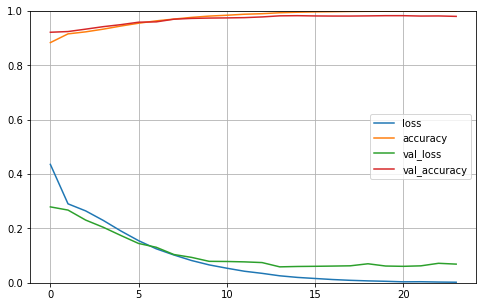

In [133]:
# Alternate code for accuracy and loss
# Plot learning curves for model
pd.DataFrame(history.history).plot(figsize=(8, 5))
plt.grid(True)
plt.gca().set_ylim(0, 1) # set the vertical range to [0-1]
plt.savefig("figures/learning_curves_model_4_pca", tight_layout=False)
plt.show()

## EXPERIMENT  5

We use a Random Forest classifier to get the relative importance of the 784 features (pixels) of the 28x28 dimensional images in training set of MNIST images and select the top 70 features (pixels). We train our 'best' dense neural network using these 70 features and compare its performance to the the DNN models from EXPERIMENTS 3 and 4.

## Reducing dimensionality of the data with Random Forests

We create a Random Forest Classifier (with the default 100 trees) and use it to find the relative importance of the 784 features (pixels) in the training set. We produce a heat map to visual the relative importance of the features (using code from Hands On Machine Learning by A. Geron). Finally, we select the 70 most important feature (pixels) from the training, validation and test images to test our 'best' model on.

In [49]:
# Define and train model
rnd_clf = RandomForestClassifier(n_estimators=100, random_state=42)
rnd_clf.fit(train_images,train_labels)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=None, oob_score=False, random_state=42, verbose=0,
                       warm_start=False)

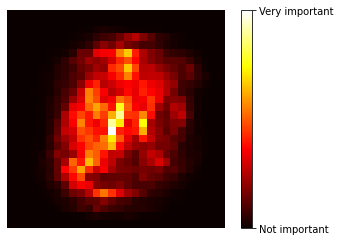

In [50]:
# https://github.com/ageron/handson-ml2/blob/master/07_ensemble_learning_and_random_forests.ipynb
import matplotlib as mpl
# import matplotlib.pyplot as plt

def plot_digit(data):
    image = data.reshape(28, 28)
    plt.imshow(image, cmap = mpl.cm.hot,
               interpolation="nearest")
    plt.axis("off")

plot_digit(rnd_clf.feature_importances_)

cbar = plt.colorbar(ticks=[rnd_clf.feature_importances_.min(), rnd_clf.feature_importances_.max()])
cbar.ax.set_yticklabels(['Not important', 'Very important'])

plt.savefig("results/feature_importance_plot_rf")
plt.show()

In [136]:
# Get the indices of the 70 most "important" features
# https://stackoverflow.com/questions/6910641/how-do-i-get-indices-of-n-maximum-values-in-a-numpy-array
n = 70
imp_arr = rnd_clf.feature_importances_
idx = (-imp_arr).argsort()[:n]          # get the indices of the 70 "most important" features/pixels
len(idx)

70

In [137]:
# Create training, validation and test images using just the 70 pixel locations obtained above
train_images_sm = train_images[:,idx]
val_images_sm = val_images[:,idx]
test_images_sm = test_images[:,idx]
train_images_sm.shape, val_images.shape, test_images_sm.shape # the reduced images have dimension 70

((55000, 70), (5000, 784), (10000, 70))

## Visualize the 70 pixels

We convert the array of indexes to ordered pairs and plot them as red circles on the second training image. 
These are the feature we are training our neural network on. 

In [138]:
# to convert an index n, 0<= n < 784
def pair(n,size):
    x = n//size 
    y = n%size
    return x,y

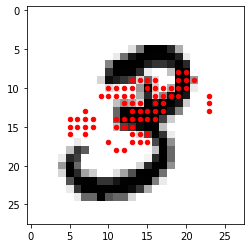

In [139]:
# Visualize features
plt.imshow(train_images[1].reshape(28,28),cmap='binary')
x, y = np.array([pair(k,28) for k in idx]).T
plt.scatter(x,y,color='red',s=20)

## Build 'best' network (before reducing dimensions)

Recall from `Experiment 3` that our network consists of a sequence of two `Dense` layers, which are densely-connected (also called "fully-connected") neural layers. 

The first `Dense` layer, the hidden layer, consists of `700 nodes`.

The second (and last) layer is a 10-way "softmax" layer, which means it will return an array of 10 probability scores (summing to 1). Each  score will be the probability that the current digit image belongs to one of our 10 digit classes.

In [140]:
# If loading previous model:
# model = model_5()
# model_5 = load_model_5('results/mnist_model_4.h5')

model_5 = models.Sequential()
model_5.add(layers.Dense(700, activation='sigmoid', input_shape=(28 * 28,)))
model_5.add(layers.Dense(10, activation='softmax')) 

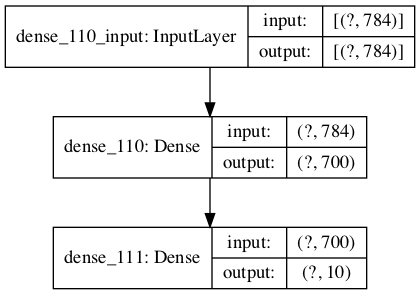

In [142]:
# Plot model
keras.utils.plot_model(model_5, "figures/mnist_model_5hnode.png", show_shapes=True) # plot a graph of the model

In [143]:
model_5.summary()

Model: "sequential_56"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_110 (Dense)            (None, 700)               549500    
_________________________________________________________________
dense_111 (Dense)            (None, 10)                7010      
Total params: 556,510
Trainable params: 556,510
Non-trainable params: 0
_________________________________________________________________


## Compile model

To make our network ready for training, we need to pick three more things, as part of "compilation" step:

* A loss function: the is how the network will be able to measure how good a job it is doing on its training data, and thus how it will be able to steer itself in the right direction.
* An optimizer: this is the mechanism through which the network will update itself based on the data it sees and its loss function.
* Metrics to monitor during training and testing. Here we will only care about accuracy (the fraction of the images that were correctly classified).

In [144]:
# For use with non-categorical labels
model_5.compile(optimizer='Adam',
                loss='sparse_categorical_crossentropy',
                metrics=['accuracy'])

## Train model

We are now ready to train our network, which in Keras is done via a call to the `fit` method of the network: 
we "fit" the model to its training data. We train the model for 30 epochs with batch size 32 (the default).

In [145]:
# If loading previous model:
# model = model_2()
# model = load_model_3('results/keras_mnist_model_3.h5')

# Train the model
start_time = time.time()
history = model_5.fit(train_images, train_labels, epochs=30,
                    validation_data=(val_images, val_labels),
                    callbacks=[keras.callbacks.EarlyStopping(patience=10)])
elapsed_time = time.time() - start_time
print('--------------------------')
print('Training time in seconds: ', round(elapsed_time,2))
print('--------------------------')

# Saving models locally after fitting
save_dir = "results/"
model_name = 'mnist_model_5.h5'
model_path = os.path.join(save_dir, model_name)
model_5.save(model_path)
print('Saved trained model at %s ' % model_path)
print('--------------------------')

Train on 55000 samples, validate on 5000 samples
Epoch 1/30
55000/55000 [==============================] - 26s 469us/sample - loss: 0.3430 - accuracy: 0.9010 - val_loss: 0.1968 - val_accuracy: 0.9426
Epoch 2/30
55000/55000 [==============================] - 23s 416us/sample - loss: 0.1789 - accuracy: 0.9469 - val_loss: 0.1325 - val_accuracy: 0.9624
Epoch 3/30
55000/55000 [==============================] - 23s 418us/sample - loss: 0.1172 - accuracy: 0.9645 - val_loss: 0.0990 - val_accuracy: 0.9710
Epoch 4/30
55000/55000 [==============================] - 23s 424us/sample - loss: 0.0822 - accuracy: 0.9755 - val_loss: 0.0825 - val_accuracy: 0.9746
Epoch 5/30
55000/55000 [==============================] - 23s 423us/sample - loss: 0.0589 - accuracy: 0.9821 - val_loss: 0.0802 - val_accuracy: 0.9748
Epoch 6/30
55000/55000 [==============================] - 24s 427us/sample - loss: 0.0429 - accuracy: 0.9866 - val_loss: 0.0700 - val_accuracy: 0.9794
Epoch 7/30
55000/55000 [=====================

In [146]:
hist_dict = history.history
hist_dict.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

In [147]:
print(f'''acc: {hist_dict['accuracy'][-1]:.4}, val acc: {hist_dict['val_accuracy'][-1]:.4},
loss: {hist_dict['loss'][-1]:.4}, val loss: {hist_dict['val_loss'][-1]:.4}''')

acc: 0.9993, val acc: 0.9784,
loss: 0.00188, val loss: 0.1009


## Test model

Evaluate the model on the test dataset.

In [148]:
test_loss, test_acc = model_5.evaluate(test_images, test_labels)

10000/10000 [==============================] - 1s 123us/sample - loss: 0.1063 - accuracy: 0.9769


In [149]:
print(f'test accuracy: {test_acc}, test loss: {test_loss}')

test accuracy: 0.9768999814987183, test loss: 0.10626666153988776


## Build, train and test the model on the new data

We modify the model to take input with dimension (70,)

In [150]:
model_5_rf = models.Sequential()
model_5_rf.add(layers.Dense(700, activation='relu', input_shape=(70,)))
model_5_rf.add(layers.Dense(10, activation='softmax'))  

In [151]:
# Compile the model
model_5_rf.compile(optimizer='Adam',
                loss='sparse_categorical_crossentropy',
                metrics=['accuracy'])

In [152]:
# Train the model
start_time = time.time()
history = model_5_rf.fit(train_images_sm, train_labels, epochs=30,
                    validation_data=(val_images_sm, val_labels),
                    callbacks=[keras.callbacks.EarlyStopping(patience=10)])
elapsed_time = time.time() - start_time
print('--------------------------')
print('Training time in seconds: ', round(elapsed_time,2))
print('--------------------------')

# Saving models locally after fitting
save_dir = "results/"
model_name = 'mnist_model_5_rf.h5'
model_path = os.path.join(save_dir, model_name)
model_5_rf.save(model_path)
print('Saved trained model at %s ' % model_path)
print('--------------------------')

Train on 55000 samples, validate on 5000 samples
Epoch 1/30
55000/55000 [==============================] - 10s 179us/sample - loss: 0.4589 - accuracy: 0.8613 - val_loss: 0.3001 - val_accuracy: 0.9124
Epoch 2/30
55000/55000 [==============================] - 8s 153us/sample - loss: 0.2663 - accuracy: 0.9190 - val_loss: 0.2508 - val_accuracy: 0.9254
Epoch 3/30
55000/55000 [==============================] - 8s 142us/sample - loss: 0.2143 - accuracy: 0.9327 - val_loss: 0.2180 - val_accuracy: 0.9338
Epoch 4/30
55000/55000 [==============================] - 8s 148us/sample - loss: 0.1854 - accuracy: 0.9417 - val_loss: 0.1835 - val_accuracy: 0.9446
Epoch 5/30
55000/55000 [==============================] - 8s 149us/sample - loss: 0.1639 - accuracy: 0.9484 - val_loss: 0.1823 - val_accuracy: 0.9448
Epoch 6/30
55000/55000 [==============================] - 8s 151us/sample - loss: 0.1493 - accuracy: 0.9529 - val_loss: 0.1771 - val_accuracy: 0.9478
Epoch 7/30
55000/55000 [==========================

In [153]:
hist_dict = history.history
hist_dict.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

In [154]:
print(f'''acc: {hist_dict['accuracy'][-1]:.4}, val acc: {hist_dict['val_accuracy'][-1]:.4},
loss: {hist_dict['loss'][-1]:.4}, val loss: {hist_dict['val_loss'][-1]:.4}''')

acc: 0.982, val acc: 0.9542,
loss: 0.05598, val loss: 0.1806


## Test model

Evaluate the model on the test dataset.

In [156]:
test_loss, test_acc = model_5_rf.evaluate(test_images_sm, test_labels)

10000/10000 [==============================] - 1s 89us/sample - loss: 0.1956 - accuracy: 0.9482


In [157]:
print(f'test accuracy: {test_acc}, test loss: {test_loss}')

test accuracy: 0.948199987411499, test loss: 0.19557065222747624


## Comparison of the three models: "best", PCA, and Random Forest

The performance of the this newest model is surprisingly good given the dimensions were reduced from 784 to 70. Future experiments could reduce the dimensions from 784 to 154 so we can compare the effects of the `PCA` and `Random Forest Classifier` approaches to dimension reduction on the performance of our `best` model. As we noted in our analysis in `EXPERIMENT 3`, using `PCA` to reduce the number of dimensions from 784 to 154 had no negative impact on the performance of our 'best' model.

**Figure 16: Learning curves for Model 5 with reduced dimensions (via Random Forest)**

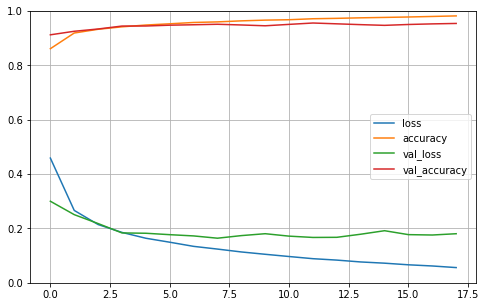

In [158]:
# Alternate code for accuracy and loss
# Plot learning curves for model
pd.DataFrame(history.history).plot(figsize=(8, 5))
plt.grid(True)
plt.gca().set_ylim(0, 1) # set the vertical range to [0-1]
plt.savefig("learning_curves_model_5_rf", tight_layout=False)
plt.show()